[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/096_ml_unsupervised/096_ml_unsupervised.ipynb)

## 2. Aprendizaje no supervisado. Aplicación del modelo mini-batch K-Means

### 2.1 Cargar el conjunto de datos Fashion-MNIST utilizando la función fetch_openml.


Con el método astype se convierte los valores de las etiquetas del conjunto de datos mnist a tipo de datos int64 (enteros de 64 bits), que es un requisito para operaciones en Python.

In [40]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd


mnist= pd.read_csv('chineseMNIST.csv')


In [41]:
print(mnist.head())

   pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel_8  pixel_9  ...  pixel_4088  pixel_4089  pixel_4090  pixel_4091  \
0        0        0  ...           0           0           0           0   
1        0        0  ...           0           0           0           0   
2        0        0  ...           0           0           0           0   
3        0        0  ...           0           0           0           0   
4        0        0  ...           0           0           0           0   

   pixel_4092  pixel_4093  pixel_4094  pixel_4095  label  character  
0         

In [42]:
mnist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Columns: 4098 entries, pixel_0 to character
dtypes: int64(4097), object(1)
memory usage: 469.0+ MB


### 2.2 División del conjunto de datos mnist["data"] y las etiquetas mnist["target"] en conjuntos de entrenamiento y prueba.

In [43]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     mnist["data"], mnist["character"], random_state=42)

# Preparando X e y
X = mnist.iloc[:, :-1]  # Las primeras 4096 columnas son los píxeles de las imágenes
y = mnist['label']  

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### 2.3 Función load_next_batch(batch_size)
Con ésta función se toma un tamaño del lote como entrada y se devuelve un lote aleatorio de datos de entrada del conjunto de datos X.\
Esto se hace para implementar el aprendizaje por lotes, se utilizará muestras de datos en lugar de todo el conjunto de datos a la vez.

In [44]:
# def load_next_batch(batch_size):
#     return X[np.random.choice(len(X), batch_size, replace=False)]

def load_next_batch(batch_size):
    # Genera un array de índices aleatorios con base en la cantidad de filas en X
    random_indices = np.random.choice(len(X), batch_size, replace=False)
    # Usa .iloc para seleccionar las filas correspondientes a esos índices
    return X.iloc[random_indices]


### 2.4 Entrenamiento de un modelo de agrupamiento utilizando el algoritmo Mini-Batch K-Means

In [45]:
from sklearn.cluster import MiniBatchKMeans

k = 5                                 #Número de clústeres (grupos) en los que se desea dividir los datos.
n_init = 10                           #Número de veces que se ejecutará el algoritmo con diferentes centroides iniciales. Se elige el modelo con la inercia más baja.
n_iterations = 100                    #Número total de iteraciones para entrenar el modelo Mini-Batch K-Means.
batch_size = 100                      #Tamaño del lote (batch) de muestras que se utilizará en cada iteración del entrenamiento.
init_size = 500                       #Tamaño del conjunto de datos de inicialización -> para inicializar los centroides iniciales del algoritmo.
evaluate_on_last_n_iters = 10         #Número de últimas iteraciones en las que se evaluará la inercia para determinar el mejor modelo.

best_kmeans = None                    #Variable best_kmeans: Va almacenar el mejor modelo Mini-Batch K-Means encontrado durante el bucle de inicialización

for init in range(n_init):            #Bucle de inicialización: Itera n_init veces para entrenar el modelo con diferentes centroides iniciales.
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size, n_init=1)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

## 2.5 Modelo Mini-Batch K-Means encontrado para el entrenamiento
Se calcula la puntuación del mejor modelo Mini-Batch K-Means en relación con el conjunto de datos X. Ésto proporciona una medida de qué tan bien se ajustan los datos a los clústeres definidos por el modelo.\
La puntuación se calcula como la negativa de la inercia del modelo, que es una medida de la suma de las distancias cuadradas de las muestras a su centroide más cercano.\
Se prefiere una puntuación más alta que va indicar que el modelo tiene una inercia menor y que se ha agrupado mejor los datos.


In [46]:
best_kmeans.score(X)

-10415615534.166164

Observación: El algoritmo de 'mini-batch K-Means' es más rápido que 'K-Means' normal, pero su precisión no es mejor.

### 2.6 Encontrar el número óptimo de grupos aplicando la métrica silhouette score.
La métrica silhouette score se basa en el cálculo del coeficiente de silueta (silhouette coefficient) de todas las muestras del dataset como $(b-a)/\mathrm{max}(a,b)$ donde $a$ es la distancia mínima al resto de muestras del mismo grupo y $b$ es la distancia media de los grupos más cercanos.\
El coeficiente de silueta varía entre -1 y 1. Un coeficiente de silueta cercano a 1 indica que la muestra está bien clasificada en su propio clúster y lejos de los clústeres vecinos. Un coeficiente de silueta cercano a -1 indica que la muestra puede estar mal clasificada en su propio clúster y cerca de los clústeres vecinos. Un coeficiente de silueta cercano a 0 indica que la muestra está cerca del límite de decisión entre dos clústeres.

In [47]:
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)


KMeans(n_clusters=5, random_state=42)

In [48]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.22759364880913496

#### Observación:
El coeficiente de silueta obtenido de 0.813042 nos indica que las muestras están bien agrupadas en sus respectivos clústeres y que hay una buena separación entre los clústeres. También nos indica que el modelo de Mini-Batch K-Means ha generado clústeres de alta calidad para nuestro conjunto de datos.








## Calcular la métrica para diferentes números de clusters 'k'
Se va a determinar la calidad de los clusters generados por KMeans para diferentes valores de 'k' (1 a 10)  utilizando el coeficiente de silueta como métrica de evaluacion.\
Objetivo: Encontrar el valor óptimo de 'k'.

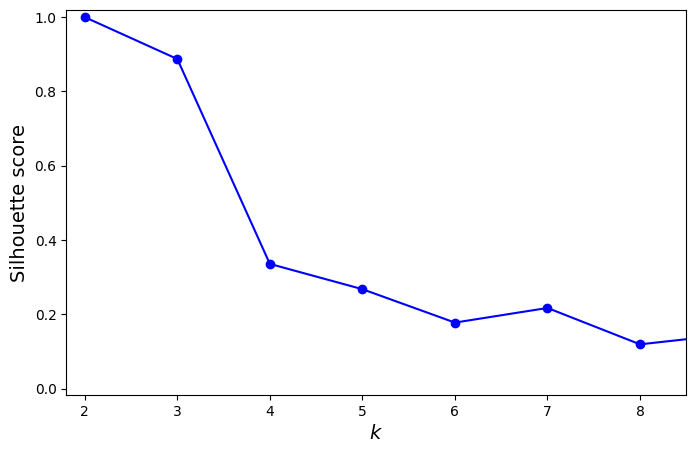

In [50]:
import matplotlib.pyplot as plt
kmeans_per_k = [KMeans(n_clusters=k, n_init = 10, random_state=42).fit(X)
                for k in range(1, 16)]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 5))
plt.plot(range(2, 16), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7])
plt.axis([1.8, 8.5, min(silhouette_scores) - 0.02, max(silhouette_scores) + 0.02])  # Ajustamos el tamaño del eje y
plt.show()

#### Observación:
Se puede verificar que para k=5, el coeficiente de silueta es más cercano a 1. Con k=5 las muestras están mejor agrupadas.

### 2.7 Diagramas de silueta para diferentes valores de 'k'
En los diagramas se puede visualizar todos los coeficientes de silueta ordenados por grupos y su valor.

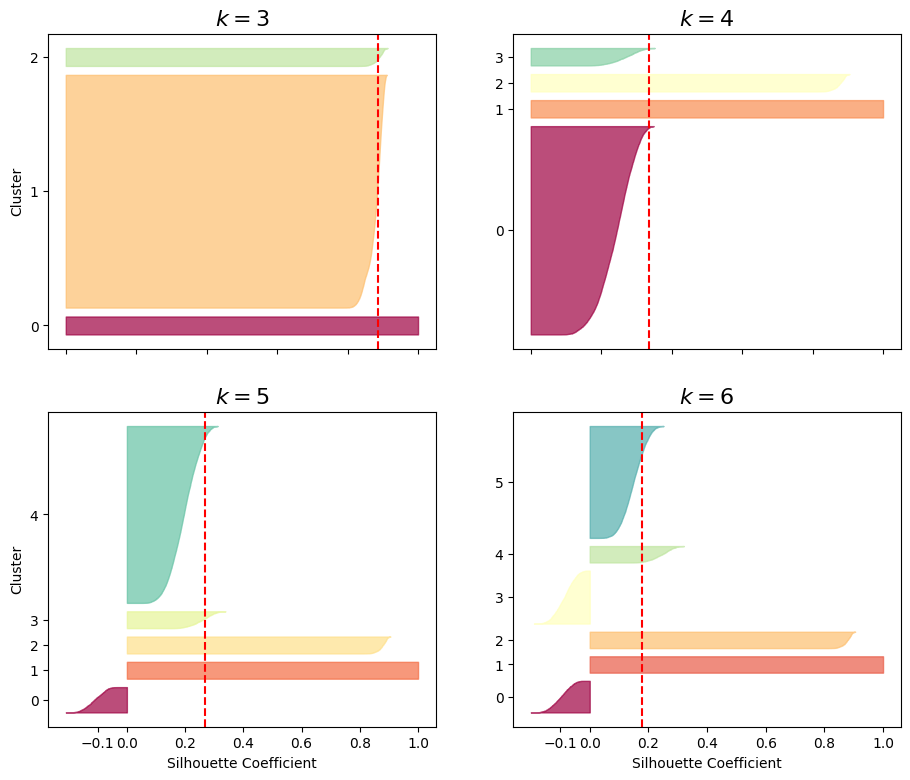

In [14]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(11, 9))

for k in (10, 11, 12, 13, 14, 15, 16):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

### 3. K-Means para aprendizaje semi-supervisado.

Permite entrenar modelos con datasets parcialmente etiquetados.\
Para el entrenamiento se utilizará el mismo dataset de la Sección 2, Fashion_MNIST.

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Cargar el dataset
mnist = pd.read_csv('chineseMNIST.csv')

# Asumiendo que las primeras 4096 columnas son los píxeles de la imagen (características)
# y la columna 'label' es la etiqueta
X = mnist.iloc[:, :-2]  # Todas las columnas excepto las dos últimas
y = mnist['label']  # Suponiendo que 'label' es la etiqueta

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### 3.1. Entrenamiento del modelo KMeans para k = 50 grupos
Mediante K-Means se encuentra clústeres en los datos de entrenamiento sin etiquetas. Estos clústeres se utilizarán como representaciones de las clases.\
kmeans.fit_transform(X_train): Entrena el modelo K-Means con los datos (X_train) y transforma los datos en distancias a los centroides de los clústeres encontrados. Los resultados se almacenan en X_digits_dist.

In [34]:
print(X_train.shape)  # Esto debe devolver algo como (n_samples, n_features)


(11250, 4096)


In [35]:
from sklearn.cluster import KMeans

k = 50
kmeans = KMeans(n_clusters=k, random_state=42)        #Crea objeto KMeans con 50 clústeres y una semilla aleatoria
X_digits_dist = kmeans.fit_transform(X_train)

### Selección de las instancias de datos más representativas de cada clúster
Función np.argmin(X_digits_dist, axis=0): Encuentra el índice del valor mínimo a lo largo del eje especificado (en este caso, el eje 0). Para cada instancia de datos, devuelve el índice del clúster más cercano (es decir, el índice del valor mínimo en X_digits_dist para cada columna).

In [36]:
idxs = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train.values[idxs]

## Visualización de las imágenes representativas de cada clúster

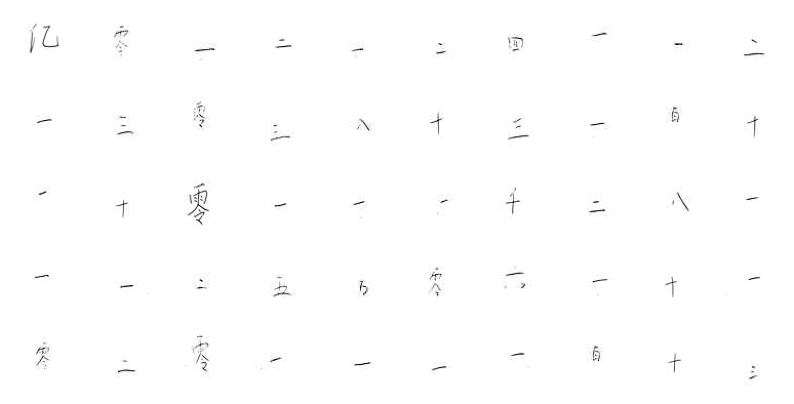

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for index, X_representative_digit in enumerate(X_representative_digits):
  plt.subplot(5, 10, index+1)
  plt.imshow(X_representative_digit.reshape(64,64), cmap="binary")
  plt.axis('off')
plt.show()

### Obtención de las etiquetas de las imágenes representativas de cada clúster
Se anotará manualmente estas etiquetas ya que disponemos de dichas etiquetas.

In [38]:
y_representative_digits = y_train.values[idxs]

### Entrenamiento del Clasificador utilizando las imágenes representativas de los clústeres como datos de entrenamiento
Luego del entrenamiento se evalúa su rendimiento en el conjunto de prueba.

In [39]:
from sklearn.linear_model import LogisticRegression                             #LogisticRegression: Clasificador lineal para clasificación binaria y multiclase.


log_reg2 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)     #Creación del clasificador
                                                                                #multi_class="ovr": Se utiliza la estrategia "one-vs-rest" para problemas de clasificación multiclase.
                                                                                #solver="lbfgs": Algoritmo a utilizar en la optimización. "Limited-memory Broyden–Fletcher–Goldfarb–Shanno".

%time log_reg2.fit(X_representative_digits, y_representative_digits)            #Entrenamiento del clasificador utilizando las imágenes representativas y sus etiquetas
log_reg2.score(X_test, y_test)                                                  #Evaluación del rendimiento del clasificador


CPU times: total: 0 ns
Wall time: 120 ms


c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.12506666666666666

Observación: Se ha obtenido una precisión de  12.50%  habiendo anotado solo 50 imágenes, pero las más representativas.

### Entrenamiento del modelo con 50 imágenes aleatorias

In [25]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg.fit(X_train[:50], y_train[:50])
log_reg.score(X_test, y_test)

CPU times: total: 0 ns
Wall time: 118 ms


0.15973333333333334

#### Observación:
Al entrenar el mismo modelo con 50 imágenes aleatorias nos da una precisión de 15.97%, menor al entrenamiento con imágenes representativas.
Conclusión: En el entrenamiento no es tan importante la cantidad de datos, sino la calidad.

### Asignar automáticamente las etiquetas de las muestras representativas a todas las muestras que pertenecen al mismo grupo (clúster) en el conjunto de entrenamiento
Como tenemos un clasificador, se puede usar para anotar de manera automática el resto de imágenes. Esto se hace para propagar las etiquetas y utilizarlas en el entrenamiento de un modelo supervisado que puede ser útil en enfoques semi-supervisados.

In [26]:
y_train_propagated = np.empty(len(X_train))
for i in range(k):
  y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

### Entrenamiento de un modelo de regresión logística utilizando las etiquetas propagadas y_train_propagated en lugar de las etiquetas originales y_train
El entrenamiento se realiza utilizando las primeras 1000 imágenes del conjunto de entrenamiento (X_train[:1000]) y las etiquetas propagadas correspondientes (y_train_propagated[:1000]).

In [27]:
log_reg3 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg3.fit(X_train[:4000], y_train_propagated[:4000])
log_reg3.score(X_test, y_test)

CPU times: total: 23.6 s
Wall time: 37.9 s


0.17653333333333332

#### Observación:
Para el conjunto de prueba, se obtiene una precisión de 17.14% lo que significa que nuestro clasificador no ha mejorado. Ésto se debe a que no todas las imágenes están bien agrupadas.\
Se podría mejorar asignando etiquetas a las muestras más cercanas a la imagen más representativa de cada grupo o con técnicas de aprendizaje activo (siguiente sección).

## 4. Aprendizaje Activo (active Learning)

Se va a entrenar el modelo de manera iterativa, incluyendo en cada iteración nuevas muestras al dataset identificando ejemplos en las que el modelo tiene más dificultades.

In [28]:
probas = log_reg3.predict_proba(X_train[:4000])
labels_ixs = np.argmax(probas, axis=1)
labels = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])
sorted_ixs = np.argsort(labels)
labels[sorted_ixs[:10]]

array([0.79988753, 0.80985236, 0.84409476, 0.85466397, 0.86232034,
       0.86625184, 0.86824047, 0.86848384, 0.87455299, 0.87622644])

#### Observación:
Los resultados muestran probabilidades cercanas a 1, indica que el modelo tiene una alta confianza en sus predicciones para esas muestras específicas. Por tanto, éstas muestras no se seleccionarán para ser etiquetadas manualmente y ser agregadas al conjunto de entrenamiento.

### Visualizar los ejemplos que tienen las probabilidades más bajas de ser clasificadas correctamente por el modelo de regresión logística
Con X_lowest = X_train.values[:10000][sorted_ixs[:k]] se selecciona los primeros 1000 ejemplos del conjunto de datos  X_train y se reordena según los índices de las probabilidades, ordenadas de menor a mayor.\
La variable k define cuantas muestras con las probabilidades más bajas se van a seleccionar.

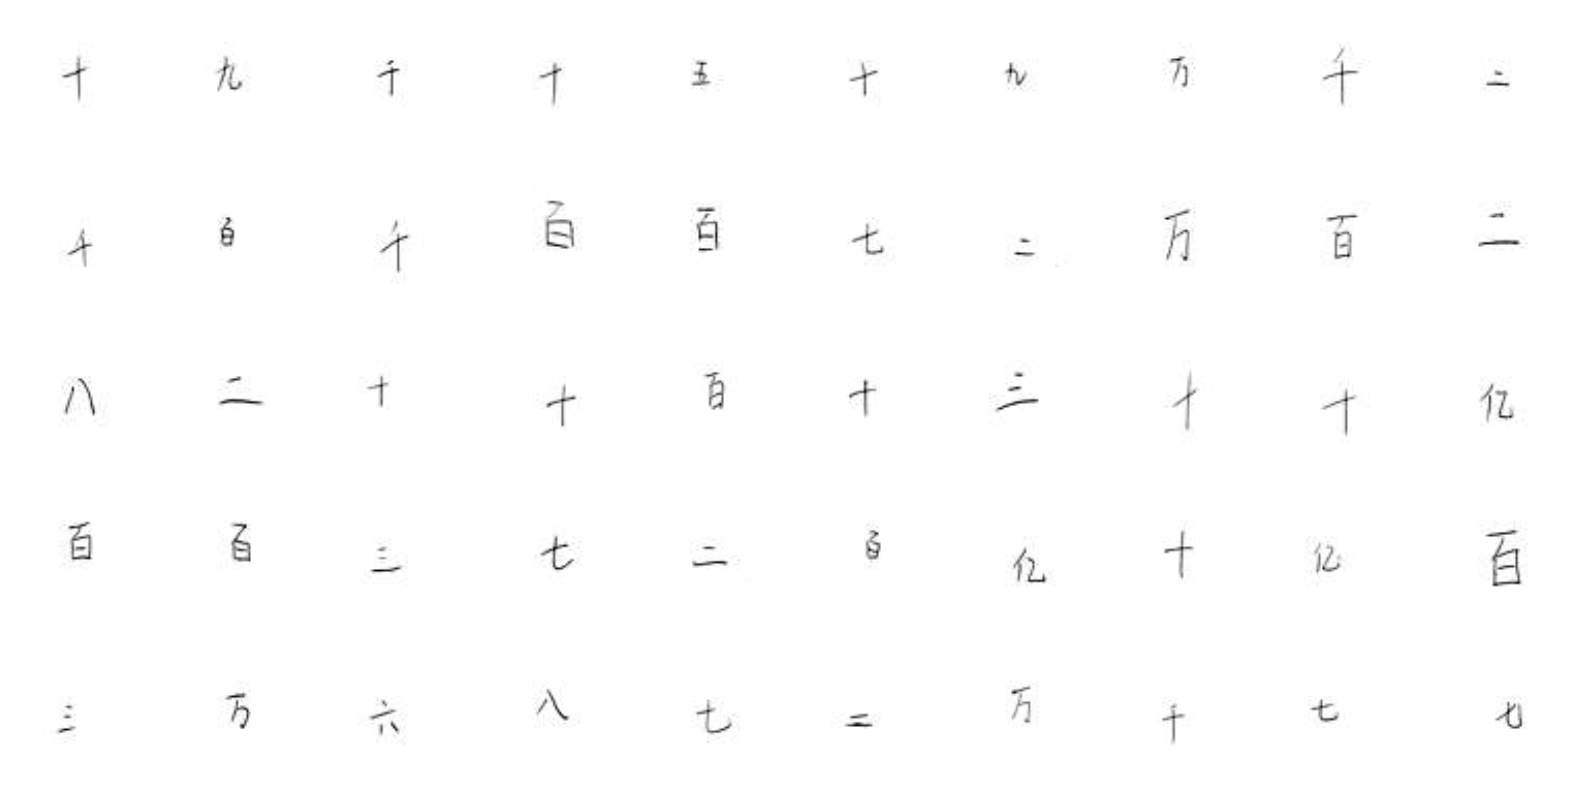

In [29]:
X_lowest = X_train.values[:4000][sorted_ixs[:k]]
# Definir k correctamente (número de imágenes a mostrar)
k = len(X_lowest)

# Calcular el número de filas y columnas
ncols = 10
nrows = k // ncols + (1 if k % ncols != 0 else 0)

# Crear la figura
plt.figure(figsize=(ncols * 2, nrows * 2))

# Crear subplots para cada imagen en X_lowest
for index, img in enumerate(X_lowest):
    plt.subplot(nrows, ncols, index + 1)
    plt.imshow(img.reshape(64, 64), cmap="binary", interpolation="bilinear")
    plt.axis('off')

# Mostrar la figura
plt.show()

## Selección de las etiquetas que corresponden a los primeros 1000 ejemplos del conjunto de datos (y_train)
 Similar a X_lowest. Se reordena según los índices de las probabilidades, de menor a mayor. 'k' define cuántas de las etiquetas de los ejemplos con las probabilidades más bajas se van a seleccionar.

In [30]:
y_lowest = y_train.values[:4000][sorted_ixs[:k]]
y_lowest

array([       10,         9,      1000,        10,         5,        10,
               9,     10000,      1000,         2,      1000,       100,
            1000,       100,       100,         7,         2,     10000,
             100,         2,         8,         2,        10,        10,
             100,        10,         3,        10,        10, 100000000,
             100,       100,         3,         7,         2,       100,
       100000000,        10, 100000000,       100,         3,     10000,
               6,         8,         7,         2,     10000,      1000,
               7,         7], dtype=int64)

## Propagación de etiquetas
Mediante el proceso de propagación de etiquetas, se actualiza el conjunto de etiquetas de entrenamiento con las etiquetas reales de las muestras seleccionadas que el modelo encuentra más difíciles de clasificar correctamente. Esto se hace para mejorar la calidad del conjunto de datos de entrenamiento y el rendimiento del modelo.

In [31]:
y_train2 = y_train_propagated[:4000].copy()
y_train2[sorted_ixs[:k]] = y_lowest

## Entrenamiento con el modelo de regresión logística utilizando las etiquetas actualizadas y_train2

In [32]:
log_reg5 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg5.fit(X_train[:4000], y_train2)
log_reg5.score(X_test, y_test)

CPU times: total: 22.3 s
Wall time: 38.7 s


0.17573333333333332

La precisión del modelo se evalúa con los datos de prueba X_test, y_test. Ésta alcanza a 17.6%.